## Importing Modules

In [1]:
import numpy as np 
import os

import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ModelCheckpoint
import tensorflow as tf

In [2]:
## Setting up physical Devices:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass    

In [49]:
# Defining Constants 

IMG_WIDTH = 224
IMG_HEIGHT = 224
NUM_CHANNELS = 3   # 3 channels - coloured UI screenshots images 
NUM_CLASSES = 2  
BATCH_SIZE = 32
EPOCHS = 10

In [4]:
cv2.imread(os.path.join('dataset', 'approved-ss', 'mobile-view'))

# Loading Data:

In [5]:
approved_mobile_path = os.path.join('dataset', 'approved-ss', 'mobile-view')
approved_desktop_path = os.path.join('dataset', 'approved-ss', 'desktop-view')

In [6]:
other_mobile_path = os.path.join('dataset', 'other-ss', 'mobile-view')
other_desktop_path = os.path.join('dataset', 'other-ss', 'desktop-view')

In [7]:
approved_desktop_list = os.listdir(approved_desktop_path)
approved_mobile_list = os.listdir(approved_mobile_path)

other_mobile_list = os.listdir(other_mobile_path)
other_desktop_list = os.listdir(other_desktop_path)

In [8]:
def load_data(path_to_dir, path_to_dir_list, approved=True):
    label = 1
    if not approved:
        label = 0
    imgs = []
    for file in path_to_dir_list:
        # path = os.path.join(path_to_dir, file)
        img = cv2.imread(os.path.join(path_to_dir, file))
        img = img[:, :-21]
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        # print(len(img))
        imgs.append([img, label])
    return imgs

# load_data(approved_desktop_path, approved_desktop_list, True
            # path to dir         list of imgs file names   labels

In [9]:
# Loading Datasets

In [10]:
approved_mobile_data = load_data(approved_mobile_path, approved_mobile_list, True)
approved_desktop_data = load_data(approved_desktop_path, approved_desktop_list, True)

In [11]:
other_mobile_data = load_data(other_mobile_path, other_mobile_list, False)
other_desktop_data = load_data(other_desktop_path, other_desktop_list, False)

In [12]:
len(other_mobile_data)

147

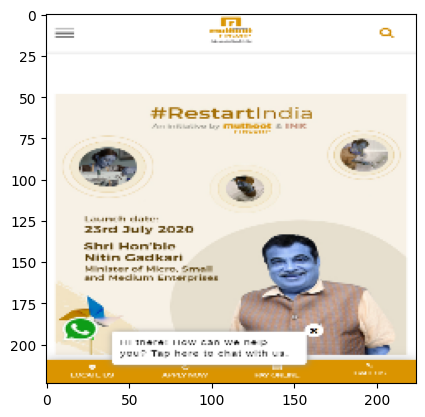

In [13]:
plt.imshow(other_mobile_data[0][0])

## Combining Data, Shuffling both mobile and desktop view collected datasets:

In [14]:
combined_mobile_data = approved_mobile_data + other_mobile_data
combined_desktop_data = approved_desktop_data + other_desktop_data

In [15]:
np.random.seed(30)
np.random.shuffle(combined_mobile_data)
np.random.shuffle(combined_desktop_data)

In [16]:
# Converting to Array:
X_mobile = []
y_mobile = []
X_desktop = []
y_desktop  = []
for img, label in combined_mobile_data:
    X_mobile.append(img)
    y_mobile.append(label)
for img, label in combined_desktop_data:
    X_desktop.append(img)
    y_desktop.append(label)

X_mobile = np.array(X_mobile)
X_desktop = np.array(X_desktop)
y_mobile = np.array(y_mobile)
y_desktop = np.array(y_desktop)

In [17]:
X_mobile.shape

(385, 224, 224, 3)

In [18]:
X_desktop.shape

(378, 224, 224, 3)

## Preprocessing Data:

In [19]:
def preprocess_data(img_data): 
    
    # Normalizing:
    img_data = img_data.astype('float32')
    img_data /= 255.0
    return img_data

In [20]:
X_mobile = preprocess_data(X_mobile)
X_desktop = preprocess_data(X_desktop)

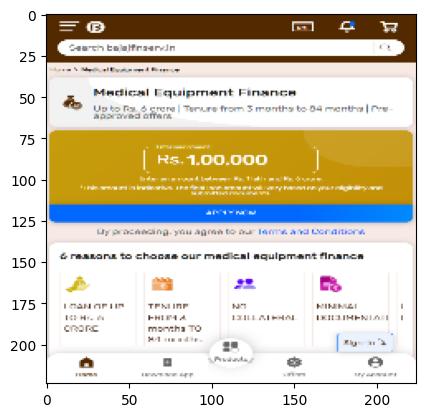

In [23]:
plt.imshow(X_mobile[0])

# TRAIN-TEST Data Splitting:

In [22]:
X_mobile_train, X_mobile_test, y_mobile_train, y_mobile_test = train_test_split(X_mobile, y_mobile, test_size=0.15)
X_desktop_train, X_desktop_test, y_desktop_train, y_desktop_test = train_test_split(X_desktop, y_desktop, test_size=0.15) 

# STLYLE CHECK ARCHITECTURE BUILDING: 🔨

In [28]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Dense, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint

In [41]:
base_model_mobile = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_desktop = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [42]:
x_mobile = base_model_mobile.output
x_mobile = GlobalAveragePooling2D()(x_mobile)

x_desktop = base_model_desktop.output
x_desktop = GlobalAveragePooling2D()(x_desktop)

# Add a fully-connected layer
x_mobile = Dense(1024, activation='relu')(x_mobile)
x_desktop = Dense(1024, activation='relu')(x_desktop)

# Add a logistic layer -- we have 1 class
predictions_mobile = Dense(1, activation='sigmoid')(x_mobile)
predictions_desktop = Dense(1, activation='sigmoid')(x_desktop)

In [43]:
model_mobile.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [38]:
# model_desktop.summary()

---
### Models to be Trained: 🤛

In [44]:
model_mobile = Model(inputs=base_model_mobile.input, outputs=predictions_mobile)
model_desktop = Model(inputs=base_model_desktop.input, outputs=predictions_desktop)

### Training Only Top layers:

In [45]:
for layer in base_model_mobile.layers:
    layer.trainable = False
for layer in base_model_desktop.layers:
    layer.trainable = False

In [47]:
# Compiling models and adding Optimizers

model_mobile.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())
model_desktop.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())

# Check Point Addition:

- **Adding Best weights**

In [50]:
checkpoint_mobile = ModelCheckpoint('best_weights_MOBILE.h5', monitor='val_loss', save_best_only=True)
checkpoint_desktop = ModelCheckpoint('best_weights_DESKTOP.h5', monitor='val_loss', save_best_only=True)

---

# Training StyleCheck Model Architecture: 

## 1. MODEL training for Mobile Applications:

In [ ]:
model_mobile.fit(
    X_mobile_train, y_mobile_train,
    epochs=EPOCHS,
    validation_data=(X_mobile_test, y_mobile_test),
    callbacks=[checkpoint_mobile],
    batch_size=BATCH_SIZE
)

## 2. MODEL training for WEB Applications: 

In [ ]:
model_desktop.fit(
    X_desktop_train, y_desktop_train,
    epochs=EPOCHS,
    validation_data=(X_desktop_test, y_desktop_test),
    callbacks=[checkpoint_desktop],
    batch_size=BATCH_SIZE
)